# Neural Nets Understood through Euler Method
This attempts (and fails) to outline how complex neural net behaviour can be understood through euler method. 

First we'll do a quick revision of the euler method than we'll follow this with 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras as kr
from mpl_toolkits.mplot3d import Axes3D

##  Euler Method Example

Let's start with a trajectory problem. To add a little complexity let's add a weak constant wind force and a strange momentum shift in z. Let's also add a constant wind force. For initial conditions let's start at $x,y,z = 0,0,0$ and $v_x,v_y,v_z = 5,0,0.1$

$\frac{d^2x}{dt^2}= -9.8$

$\frac{d^2y}{dt^2}= 0.1$

$\frac{dz}{dt}= 0.1$

To remind ourselve eulers method we can think of it as evaluating the first term of the taylor series. We can write this as:

$\frac{dx}{dt}|_{t=t_0} = f(x_0,t_0)$

$x = x_0 + (t-t_0) f(x_0,t_0)$

using this repeatly give us:

$x_{n+1} = x_n + (t_{n+1}-t_n) f(x_n,t_n)$   or  $x_{n+1} = x_n + h f(x_n,t_n)$ for a constant time jump

We apply it twice to get the second derivative.

$\frac{d^2x}{dt^2}= g(v_0,x_0,t_0)$

$x = x_0 + hv_0 + h^2 g(v_0,x_0,t_0)$

So for our example we use the interative forms:

$x_{n+1} = x_n + h v_{x,n} -9.8 h^2 $

$v_{x,n+1} = v_n - 9.8h$

$y_{n+1} = y_n + h v_{y,n} + 0.1 h^2 $

$v_{y,n+1} = v_{y,n} +0.1 h $

$z_{n+1} = z_n +0.1 h $

Because x and y are independent this problem becomes simple but also interesting enough. We can decided how far we want to make our time jumps.

<IPython.core.display.Javascript object>


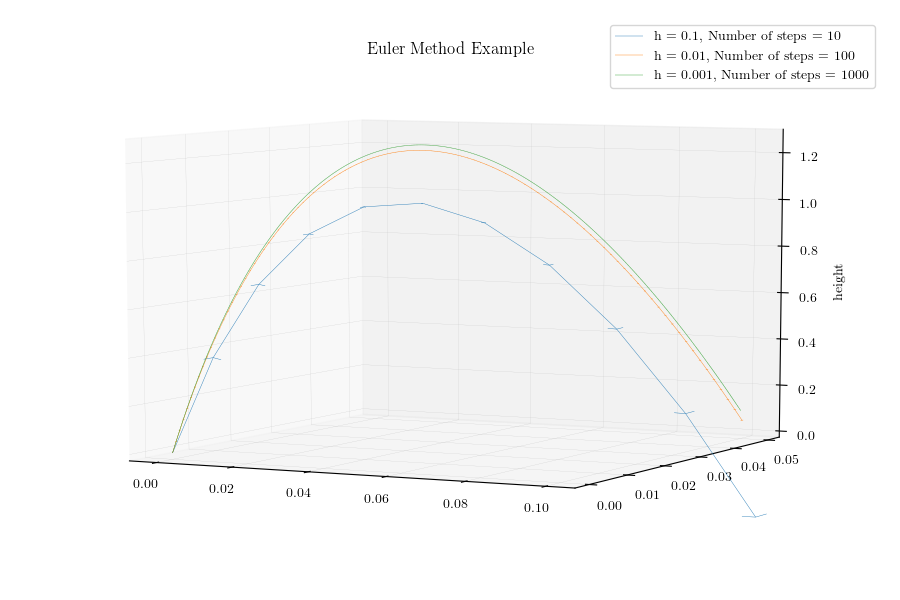

In [3]:
#Euler Method example
%matplotlib notebook 
hs= np.array([0.1, 0.01, 0.001])
data = []
for h in hs:
    #Number of interations to hit t=1
    numberofinterations = int(1/h)
    #Initial States
    States = [[0, 0, 0, 5, 0, 0.1]]
    for j in range(numberofinterations):
        #Apply all the updates
        States.append([States[-1][0] + h*States[-1][3] - 9.8*h**2,
                       States[-1][1] + h*States[-1][4] + 0.1*h**2,
                       States[-1][2] + h*0.1,
                       States[-1][3] - 9.8*h,
                       States[-1][4] + 0.1*h,
                       0.1])
    data.append(States)
#PLotting
fig = plt.figure(figsize= (9,6), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
for i,h in enumerate(hs):
    x,y,z,vx,vy,vz = zip(*data[i])
    vx = np.concatenate([np.array(x[1:]),np.array([x[-1]])])-np.array(x)
    vy = np.concatenate([np.array(y[1:]),np.array([y[-1]])])-np.array(y)
    vz = np.concatenate([np.array(z[1:]),np.array([z[-1]])])-np.array(z)
    ax.quiver(np.array(z),np.array(y),np.array(x),vz,vy,vx,label='h = '+str(h)+', Number of steps = '+str(int(1/h)),
              color='C'+str(i),arrow_length_ratio=0.02,linewidths=0.3)
ax.legend()
ax.set_zlabel('height')
ax.set_title('Euler Method Example')
ax.view_init(elev=7, azim=297)

plt.show()

Main point to observe is that with smaller step sizes leads to more accurate point. I'll be trying to show that 'deeper' networks actually corresponds to smaller transformations.

## Depth in Neural Networks

So why is depth useful in neural networks?

Because each layer is

The problem above has a simple analytic solution and we can train a number of models of different sizes with these analytic solutions. This will help us further understand.

$x = x_0+v_{x,0}t- 4.9 t^2$

$y = y_{0}+v_{y,0}t+ 0.05 t^2$

$z = z_0+0.1 t$

We'll set: $t = 1$

To begin with we are just going to see if we can get a network to learn these equations by example.

Basically can we create a function:

$f(x_0,y_0,z_0,v_{x,0},v_{y,0},v_{z,0},t)=(x,y,z,v_x,v_y,v_z)$

We'll do this by creating a random set of vectors from (0,1). 

In [18]:
initstate = np.random.rand(100000,7)
initstate[:,0]=0
initstate[:,1]=0
initstate[:,2]=0
initstate[:,3]=5
initstate[:,4]=0
initstate[:,5]=0.1
finalstate = np.array([initstate[:,0]+initstate[:,3]*initstate[:,6]-4.9*initstate[:,6]**2,
                       initstate[:,1]+initstate[:,4]*initstate[:,6]+0.05*initstate[:,6]**2,
                       initstate[:,2]+initstate[:,5]*initstate[:,6]]).T
finalstate[:,0]=finalstate[:,0]/10
finalstate[:,1]=finalstate[:,1]*10
finalstate[:,2]=finalstate[:,2]*10
'''                       ,
                       initstate[:,3]-9.8*initstate[:,6],
                       initstate[:,4]+0.1*initstate[:,6],
                       initstate[:,5],
                      ]).T'''
from keras.layers import Dense, Input, Dropout, PReLU,LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Nadam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras import backend as K
import keras

#Because of the strangeness of our particular setup it wasn't clear to me that float32 
#would do (with 6 sig figs 0.0001% accurate)
#This is definitely overkill in conventional networks
keras.backend.set_epsilon(1e-13)
keras.backend.set_floatx('float64')
biason=True

inputs = Input(shape = (7,))
x = Dense(3,use_bias=biason, activation='elu')(inputs)
'''

SWITCH THESE OUT FOR DIFFERENT RESULTS

# 5 layers
for i in range(4):                 
    x = Dense(3,use_bias=biason,activation='elu')(x)
x = Dense(3,use_bias=biason,activation='elu')(x)
model5layer = Model(inputs=inputs,outputs=x)

# 1 layers
for i in range(0):                 
    x = Dense(3,use_bias=biason,activation='elu')(x)
x = Dense(3,use_bias=biason,activation='elu')(x)
model5layer = Model(inputs=inputs,outputs=x)

#L2 Regularization
for i in range(40):    
    x = Dense(3,use_bias=biason,activation='elu',bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5))(x)
x = Dense(3,use_bias=biason,activation='elu', bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5))(x)
model5layer = Model(inputs=inputs,outputs=x)

#No Regularization
for i in range(40):                 
    x = Dense(3,use_bias=biason,activation='elu')(x)
x = Dense(3,use_bias=biason,activation='elu')(x)
model5layer = Model(inputs=inputs,outputs=x)

# L1 Regularization
for i in range(40):    
    x = Dense(3,use_bias=biason,activation='elu',bias_regularizer=regularizers.l1(1e-7),
                activity_regularizer=regularizers.l1(1e-8))(x)
x = Dense(3,use_bias=biason,activation='elu', bias_regularizer=regularizers.l1(1e-7),
                activity_regularizer=regularizers.l1(1e-8))(x)
model5layer = Model(inputs=inputs,outputs=x)


# Regularization By Identities
for i in range(20):                 
    x1 = Dense(3,use_bias=biason,activation='elu')(x)
    x = keras.layers.Average()([x1, x])
x = Dense(3,use_bias=biason,activation='elu')(x)

# Regularization By Identities Complex
for i in range(20):                 
    x1 = Dense(3,use_bias=biason,activation='elu')(x)
    x2 = Dense(3,use_bias=biason,activation='elu')(x1)
    x = keras.layers.Add()([x1, x])
x = Dense(3,use_bias=biason,activation='elu')(x)

'''
# 1 layers
for i in range(20):                 
    x1 = Dense(3,use_bias=biason,activation='elu')(x)
    x = keras.layers.Average()([x1, x])
x = Dense(3,use_bias=biason,activation='elu')(x)
model5layer = Model(inputs=inputs,outputs=x)

batch_size = 200
nb_epoch = 100
X_train=initstate
Y_train=finalstate
#model1layer.compile(optimizer="Adadelta", loss='mean_squared_logarithmic_error', metrics=['accuracy'])
#model1layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, 
#                shuffle=True)
#model2layer.compile(optimizer="Adadelta", loss='mean_squared_logarithmic_error', metrics=['accuracy'])
#model2layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1,
#                shuffle=True)
#model3layer.compile(optimizer="Adagrad", loss='mean_squared_error', metrics=['accuracy'])
#model3layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1,
#                shuffle=True)
model5layer.compile(optimizer="Nadam", loss='mean_squared_error', metrics=['accuracy'])
model5layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1,
                shuffle=True)

Epoch 1/100
100000/100000 [==============================] - 11s - loss: 0.0194 - acc: 0.9724    
Epoch 2/100
100000/100000 [==============================] - 13s - loss: 6.6960e-04 - acc: 0.9279    
Epoch 3/100
100000/100000 [==============================] - 19s - loss: 4.0941e-04 - acc: 0.9296    
Epoch 4/100
100000/100000 [==============================] - 29s - loss: 2.2037e-04 - acc: 0.9468    - E
Epoch 5/100
100000/100000 [==============================] - 14s - loss: 1.0619e-04 - acc: 0.9686    
Epoch 6/100
100000/100000 [==============================] - 26s - loss: 7.4189e-05 - acc: 0.9815    - ETA: 0s - loss: 7.5797e-05 - a
Epoch 7/100
100000/100000 [==============================] - 35s - loss: 6.6286e-05 - acc: 0.9881    
Epoch 8/100
100000/100000 [==============================] - 26s - loss: 5.7306e-05 - acc: 0.9920      ETA: 18s - 
Epoch 9/100
100000/100000 [==============================] - 5s - loss: 4.8508e-05 - acc: 0.9937     
Epoch 10/100
100000/100000 [==========

100000/100000 [==============================] - 5s - loss: 5.5497e-06 - acc: 0.9993     
Epoch 81/100
100000/100000 [==============================] - 6s - loss: 5.2061e-06 - acc: 0.9994     
Epoch 82/100
100000/100000 [==============================] - 6s - loss: 5.3927e-06 - acc: 0.9993     
Epoch 83/100
100000/100000 [==============================] - 6s - loss: 5.2032e-06 - acc: 0.9994     
Epoch 84/100
100000/100000 [==============================] - 7s - loss: 6.1423e-06 - acc: 0.9992     
Epoch 85/100
100000/100000 [==============================] - 7s - loss: 4.4497e-06 - acc: 0.9994     
Epoch 86/100
100000/100000 [==============================] - 6s - loss: 5.7469e-06 - acc: 0.9993     
Epoch 87/100
100000/100000 [==============================] - 6s - loss: 5.3818e-06 - acc: 0.9993     - ETA: 1s - loss: 4
Epoch 88/100
100000/100000 [==============================] - 5s - loss: 5.3371e-06 - acc: 0.9993     
Epoch 89/100
100000/100000 [==============================] - 5s - 

In [20]:
timestep = []
for j in range(100):
    ans = [[ 0, 0, 0, 5, 0, 0.1, .01*j]]
    interans = [[[0, 0, 0]]]
    layer_name = 'my_layer'
    for i in range(1,43):
        intermodel = Model(inputs=model5layer.input,outputs=model5layer.layers[i].output)
        interans.append(intermodel.predict(np.array(ans)))
    timestep.append(interans)
np.save("functionTimeStep40Residual.npy",np.array(timestep))




In [19]:
len(model5layer.layers)

43

# ROUGH WORK BELOW

In [ ]:
preds= []
for j in range(1):
    inits=np.array([[0,0,0,5,0,0.1,0.01*i] for i in range(350)])
    preds.append(model5layer.predict(inits))

In [13]:
initstate=np.array([[0,0,0,5,0,0.1,0.001*i] for i in range(1000)])
finalstate = np.array([initstate[:,0]+initstate[:,3]*initstate[:,6]-4.9*initstate[:,6]**2,
                       initstate[:,1]+initstate[:,4]*initstate[:,6]+0.05*initstate[:,6]**2,
                       initstate[:,2]+initstate[:,5]*initstate[:,6]]).T
finalstate[:,0]=finalstate[:,0]/10
finalstate[:,1]=finalstate[:,1]*10
finalstate[:,2]=finalstate[:,2]*10
np.save("Analytical.npy",finalstate)
#x1,y1,z1 = finalstate.T
#pred1=model1layer.predict(initstate)
#pred2=model2layer.predict(initstate)
#pred3=model4layer.predict(initstate)
#pred4=model5layer.predict(initstate)

In [ ]:
for j in range(1):
    m4w = model5layer.get_weights()
    def elu(x):
        x[x<0]=np.e**x[x<0]-1.0
        return x 
    ans=[[0,0,0,5,0,0.1,.01*j]]
    interans = [[[0,0,0]]]
    layer_name = 'my_layer'
    for i in range(1,43):
        intermodel = Model(inputs=model5layer.input,outputs=model5layer.layers[i].output)
        interans.append(intermodel.predict(np.array(ans)))
    fig = plt.figure(figsize= (9,6), tight_layout = True)
    ax = fig.add_subplot(111, projection='3d')
    x,y,z = np.array(interans)[:,0,:].T
    ax.plot(np.array(z1),np.array(y1),np.array(x1),linestyle='-',linewidth=0.4,
                  color='k', label='Analytic',alpha=0.3)
    ax.plot(np.array(z),np.array(y),np.array(x),marker='o',
                  color='C'+str(0),label='Layers',alpha=.7)
    ax.plot(np.array(z[:1]),np.array(y[:1]),np.array(x[:1]),marker='o',
                  color='C'+str(1),label='Initial')
    ax.plot(np.array(z[-1:]),np.array(y[-1:]),np.array(x[-1:]),marker='o',
                  color='C'+str(2),label='Final')
    #ax.set_zlabel('height')
    ax.legend(fontsize=20)
    ax.view_init(elev=7, azim=297)
    ax.set_axis_off()
    fig.savefig('1Visual'+str(j)+'.jpg')
plt.cla()

In [ ]:
#Single plotting round
fig = plt.figure(figsize= (9,6), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
x,y,z = finalstate.T
ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',
              color='C'+str(0),linewidths=0.3, label='Analytic')
for pred in preds:
    x,y,z = pred.T
    ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',linewidths=0.3)
#ax.legend()
ax.set_zlabel('height')
ax.set_title('Extrapolation')
ax.view_init(elev=7, azim=297)
fig.savefig('ExtendedWithRegression.jpg')

In [ ]:
fig = plt.figure(figsize= (9,6), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
x,y,z = np.array(interans)[:,0,:].T
ax.plot(np.array(z),np.array(y),np.array(x),marker='o',
              color='C'+str(0),label='Analytic')
#ax.legend()
ax.set_zlabel('height')
ax.set_title('Euler Method Example')
ax.view_init(elev=7, azim=297)
plt.show()

In [ ]:
inputs = Input(shape = (7,))
x = model2layer(inputs)
x = Dense(5,use_bias=False,activation='elu',kernel_initializer=myinit)(x)
x = Dense(3,use_bias=False,activation='elu',kernel_initializer=myinit)(x)
model4layer = Model(inputs=inputs,outputs=x)
model4layer.compile(optimizer="Adagrad", loss='mean_squared_logarithmic_error', metrics=['accuracy'])
model4layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, 
                shuffle=True)

inputs = Input(shape = (7,))
x = model4layer(inputs)
x = Dense(7,use_bias=False,activation='elu',kernel_initializer=myinit)(x)
x = Dense(3,use_bias=False,activation='elu',kernel_initializer=myinit)(x)
model5layer = Model(inputs=inputs,outputs=x)
model5layer.compile(optimizer="Adagrad", loss='mean_squared_logarithmic_error', metrics=['accuracy'])
model5layer.fit([X_train], Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, 
                shuffle=True)


In [ ]:
fig = plt.figure(figsize= (9,6), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.array(z1),np.array(y1),np.array(x1),linewidth=0.4,
                   label='Analytic',alpha=0.3)

In [5]:


fig = plt.figure(figsize= (9,6), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
x1,y1,z1 = finalstate.T
ax.scatter(np.array(z1),np.array(y1),np.array(x1),0.01*np.ones(x.shape),marker='.',
              color='C'+str(0),linewidths=0.3, label='Analytic')
#x,y,z = pred1.T
#ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',
#              color='C'+str(3),linewidths=0.3,label='1-Layers')
#x,y,z = pred2.T
#ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',
#              color='C'+str(1),linewidths=0.3,label='2-Layers')
#x,y,z = pred3.T
#ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',
#              color='C'+str(2),linewidths=0.3,label='7 Layers'),
x,y,z = pred4.T
ax.scatter(np.array(z),np.array(y),np.array(x),0.01*np.ones(x.shape),marker='.',
              color='C'+str(4),linewidths=0.3,label='12 Layers')
ax.legend()
ax.set_zlabel('height')
ax.set_title('Euler Method Example')
ax.view_init(elev=7, azim=297)
plt.show()

<IPython.core.display.Javascript object>

TypeError: expected sequence object with len >= 0 or a single integer